In [2]:
import numpy as np
import pandas as pd
import copy
import re
from collections import defaultdict
from configparser import ConfigParser
import pathlib as pl

import joblib as jl
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.decomposition import PCA
from IPython.display import Image

from src.root_path import config_path
from src.utils.subsets import cellid_subset_02, cellid_fit_set
from src.data.rasters import load_site_formated_prediction
from src.models.modelnames import modelnames
from src.models.param_tools import get_pred_err
from src.visualization.fancy_plots import squarefy
from src.visualization.palette import *

# try to compare linear sum of models
clearly the predictions of the full pop_mod_relu is smaller than the sum of its parts: STRF_long_relu and  pop_lone_relu

loading predicted response for TNC014a with modelspec
ozgf.fs100.ch18-ld-norm.l1-epcpn.seq-avgreps_wc.18x1.g-fir.1x30-lvl.1-relu.1_jk.nf10-tfinit.n.lr1e3.et3.cont-newtf.n.lr1e4.cont-svpred

loading predicted response for TNC014a with modelspec
ozgf.fs100.ch18-ld.popstate-norm.l1-dline.15.15.1-epcpn.seq-avgreps_wc.18x1.g-fir.1x15-lvl.1-relu.1-stategain.S.d_jk.nf10-tfinit.n.lr1e3.et3.cont-newtf.n.lr1e4.cont-svpred

loading predicted response for TNC014a with modelspec
ozgf.fs100.ch18-ld.popstate-norm.l1-dline.15.15.1.i.state.o.stim-epcpn.seq-avgreps_wc.Nx1-fir.1x1-lvl.1-relu.1_jk.nf10-tfinit.n.lr1e3.et3.cont-newtf.n.lr1e4.cont-svpred



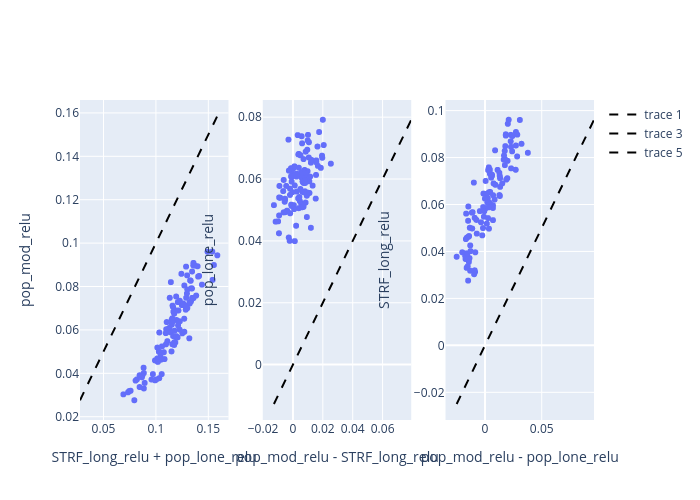

In [3]:
# for a given cell load the model strfs
site = 'TNC014a'
batch = 326
cellid = 'TNC014a-22-2'


selected_models = ['STRF_long_relu', 'pop_mod_relu', 'pop_lone_relu']
rasters = dict()
for nickname, modelname in modelnames.items():
    if nickname not in selected_models:
        continue
    rasters[nickname], goodcells = load_site_formated_prediction(site, modelname=modelname, batch=batch, cellid=cellid)


variances = {key:np.mean(val, axis=-1) for key, val in rasters.items()}


sum_var = np.mean(rasters['STRF_long_relu'] + rasters['pop_lone_relu'], axis=-1)
x = sum_var.squeeze().flatten()
y = variances['pop_mod_relu'].squeeze().flatten()
plot_range = [np.stack([x,y]).min(), np.stack([x,y]).max()]
fig_sum = px.scatter(x=x,y=y)
fig_sum.add_trace(go.Scatter(x=plot_range, y=plot_range, mode='lines', line_color='black', line_dash='dash'))


diff_var = np.mean(rasters['pop_mod_relu'] - rasters['STRF_long_relu'], axis=-1)
x = diff_var.squeeze().flatten()
y = variances['pop_lone_relu'].squeeze().flatten()
plot_range = [np.stack([x,y]).min(), np.stack([x,y]).max()]
fig_diff1 = px.scatter(x=x,y=y)
fig_diff1.add_trace(go.Scatter(x=plot_range, y=plot_range, mode='lines', line_color='black', line_dash='dash'))


diff_var = np.mean(rasters['pop_mod_relu'] - rasters['pop_lone_relu'], axis=-1)
x = diff_var.squeeze().flatten()
y = variances['pop_mod_relu'].squeeze().flatten()
plot_range = [np.stack([x,y]).min(), np.stack([x,y]).max()]
fig_diff2 = px.scatter(x=x,y=y)
fig_diff2.add_trace(go.Scatter(x=plot_range, y=plot_range, mode='lines', line_color='black', line_dash='dash'))


fig = make_subplots(1,3)
fig.add_traces(fig_sum['data'], rows=[1] * len(fig_sum['data']), cols=[1] * len(fig_sum['data']))
fig.update_xaxes(title_text='STRF_long_relu + pop_lone_relu', col=1, row=1)
fig.update_yaxes(scaleratio=1, title_text='pop_mod_relu', col=1, row=1)

fig.add_traces(fig_diff1['data'], rows=[1] * len(fig_diff1['data']), cols=[2] * len(fig_diff1['data']))
fig.update_xaxes(title_text='pop_mod_relu - STRF_long_relu', col=2, row=1)
fig.update_yaxes(scaleratio=1, title_text='pop_lone_relu', col=2, row=1)


fig.add_traces(fig_diff2['data'], rows=[1] * len(fig_diff2['data']), cols=[3] * len(fig_diff2['data']))
fig.update_xaxes(title_text='pop_mod_relu - pop_lone_relu', col=3, row=1)
fig.update_yaxes(scaleratio=1, title_text='STRF_long_relu', col=3, row=1)

# fig.show()
img_bytes = fig.to_image(format="png")
Image(img_bytes)

# Aggregate prediction results across all neurons
take the mean difference prediction error over time for each neuron, concatenate across all neurons and get principal components

In [4]:
floor = modelnames['STRF_long_relu']
selected  = ['pop_lone_relu', 'pop_mod_relu']
cellids = list(cellid_subset_02) # use list to ensure order
# cellids = list(cellid_fit_set) # use list to ensure order

pooled_diff_err = defaultdict(lambda :np.empty([len(cellids), 100]))
for cc, cellid in enumerate(cellids):
    err_floor, diff_err_floor = get_pred_err(cellid, batch, floor, part='probe')
    fig = go.Figure()
    for mm, (nickname, modelname) in enumerate(modelnames.items()):
        if nickname not in selected:
            continue

        err, diff_err = get_pred_err(cellid, batch, modelname, part='probe')

        err = np.mean(err - err_floor, axis=(0,1))
        diff_err = np.mean(diff_err - diff_err_floor, axis=(0,1))

        pooled_diff_err[nickname][cc,:] = diff_err


In [5]:
pooled_diff_err['pop_mod_relu'].shape
pca = PCA(n_components=20)
toplot = pca.fit_transform(pooled_diff_err['pop_mod_relu'].T).T
toplot.shape

(20, 100)

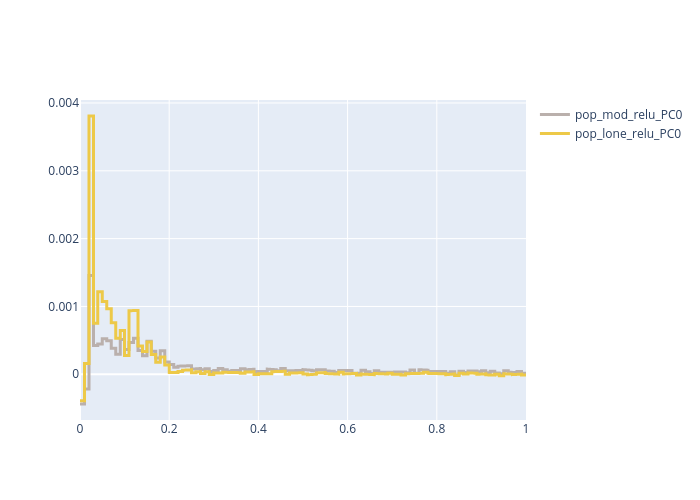

In [6]:
nPCs = 3
neu, tme = pooled_diff_err['pop_mod_relu'].shape
fs = int(re.findall('\.fs\d*\.', modelnames['pop_mod_relu'])[0][3:-1])
duration = tme / fs
time = np.linspace(0, duration, tme, endpoint=False)
colors = [Grey, Yellow, Red, Teal, Brown]

fig = go.Figure()
for mm, (nickname, pool_err) in enumerate(pooled_diff_err.items()):
    color = colors[mm % len(colors)]
    # pca = PCA(n_components=len(cellid))
    # toplot = pca.fit_transform(pool_err.T).T # PC by Time
    toplot = pool_err.mean(axis=0)

    dashings = ['solid', 'dash', 'dot']
    # for pc in range(nPCs):
    name = f'{nickname}_PC{0}'
    x, y = squarefy(time, toplot)
    fig.add_trace(go.Scatter(x=x, y=y, mode='lines',
                             line=dict(color=color,
                                       width=3,
                                       dash=dashings[0%len(dashings)]),
                             name=name, showlegend=True))

        # # inset for variance explained
        # fig.add_trace(go.Scatter(x=list(range(1,len(pca.explained_variance_ratio_)+1)),
        #                          y=np.cumsum(pca.explained_variance_ratio_),
        #                          mode='lines+markers', line_color=color, marker_color=color,
        #                          xaxis='x2', yaxis='y2', showlegend=False)
        #               )

    # fig.update_layout(xaxis2=dict(domain=[0.4,0.95], anchor='y2', title_text='PC#'),
    #                   yaxis2=dict(domain=[0.4,0.95], anchor='x2', title_text='var explained')
    #                   )

# fig.show()
img_bytes = fig.to_image(format="png")
Image(img_bytes)

# split data by last bin

In [7]:
config = ConfigParser()
config.read_file(open(config_path / 'settings.ini'))
meta = {'reliability': 0.1,  # r value
        'smoothing_window': 0,  # ms
        'raster_fs': 30,
        'montecarlo': 11000,
        'zscore': True,
        'stim_type': 'permutations'}

summary_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220310_ctx_mod_metric_DF_tstat_cluster_mass_BS'

df = jl.load(summary_DF_file)
metrics = ['integral', 'last_bin']
df = df.query(f"metric in {metrics} and mult_comp_corr == 'bf_cp' and source == 'real' and "
             f"cluster_threshold == 0.05 and "
             f"id in {list(cellids)}")
to_split = df.groupby(['metric', 'id', 'site']).agg(value=('value', 'mean'))


In [8]:
split_cells = dict()
for metric in metrics:
    view = to_split.loc[metric,:].reset_index()

    ids = view.loc[view.value>=np.median(view.value), 'id'].tolist()
    split_cells[f'{metric}_top'] = ids

    ids = view.loc[view.value<np.median(view.value), 'id'].tolist()
    split_cells[f'{metric}_bottom'] = ids

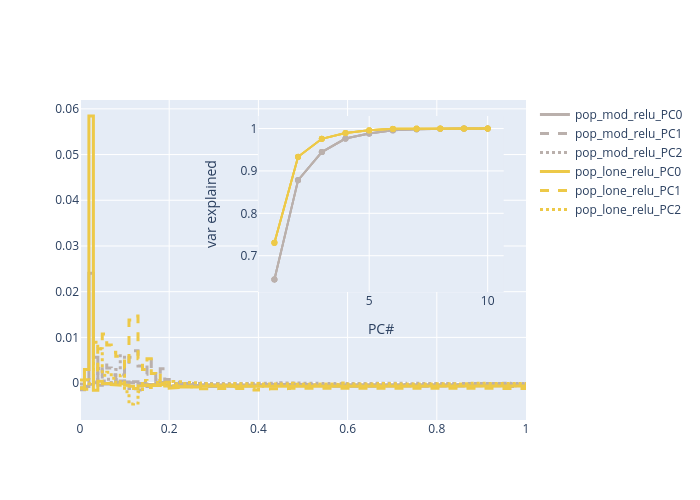

In [10]:
def plot_PCs_of_pool(cell_subset):
    nPCs = 3
    neu, tme = pooled_diff_err['pop_mod_relu'].shape
    fs = int(re.findall('\.fs\d*\.', modelnames['pop_mod_relu'])[0][3:-1])
    duration = tme / fs
    time = np.linspace(0, duration, tme, endpoint=False)
    colors = [Grey, Yellow, Red, Teal, Brown]
    fig = go.Figure()
    for mm, (nickname, pool_err) in enumerate(pooled_diff_err.items()):
        sel_neu = np.in1d(np.asarray(cellids), np.asarray(cell_subset))
        pool_err = pool_err[sel_neu,:]
        color = colors[mm % len(colors)]
        pca = PCA(n_components=sel_neu.sum())
        toplot = pca.fit_transform(pool_err.T).T # PC by Time

        dashings = ['solid', 'dash', 'dot']
        for pc in range(nPCs):
            name = f'{nickname}_PC{pc}'
            x, y = squarefy(time, toplot[pc,:])
            fig.add_trace(go.Scatter(x=x, y=y, mode='lines',
                                     line=dict(color=color,
                                               width=3,
                                               dash=dashings[pc%len(dashings)]),
                                     name=name, showlegend=True))

            # inset for variance explained
            fig.add_trace(go.Scatter(x=list(range(1,len(pca.explained_variance_ratio_)+1)),
                                     y=np.cumsum(pca.explained_variance_ratio_),
                                     mode='lines+markers', line_color=color, marker_color=color,
                                     xaxis='x2', yaxis='y2', showlegend=False)
                          )

        fig.update_layout(xaxis2=dict(domain=[0.4,0.95], anchor='y2', title_text='PC#'),
                          yaxis2=dict(domain=[0.4,0.95], anchor='x2', title_text='var explained')
                          )

    return fig

fig = plot_PCs_of_pool(split_cells['integral_top'])
img_bytes = fig.to_image(format="png")
Image(img_bytes)

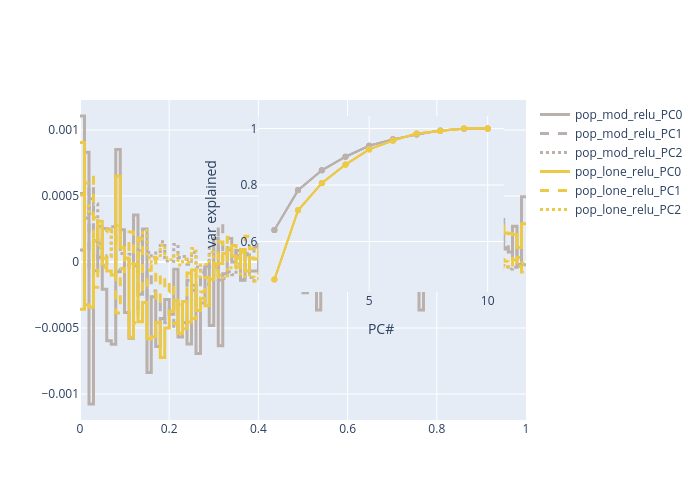

In [11]:
fig = plot_PCs_of_pool(split_cells['integral_bottom'])
img_bytes = fig.to_image(format="png")
Image(img_bytes)

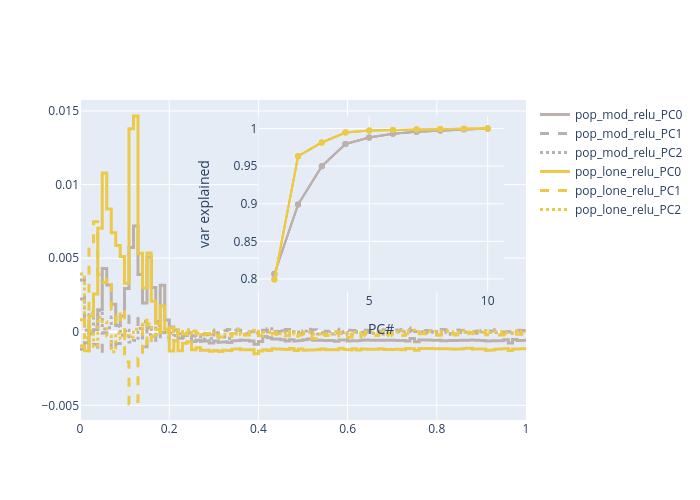

In [12]:
fig = plot_PCs_of_pool(split_cells['last_bin_top'])
img_bytes = fig.to_image(format="png")
Image(img_bytes)

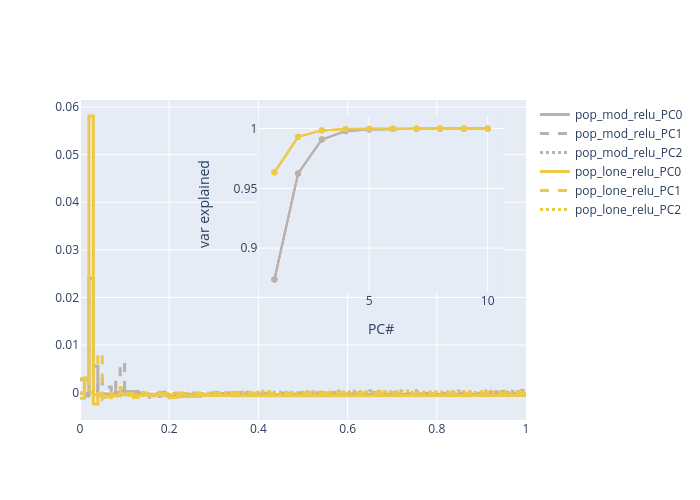

In [13]:
fig = plot_PCs_of_pool(split_cells['last_bin_bottom'])
img_bytes = fig.to_image(format="png")
Image(img_bytes)

## in conclusion
1. lower errors for low amplitude neurons, why?? less contextula modulation, bettel context model?
2. moslty around 200 ms. but not past
3. consistently lower errors for high duration neurons, better driven by pop_lone_relu than pop_mod_relu

# lets just look at the subset of significantly modulated responses


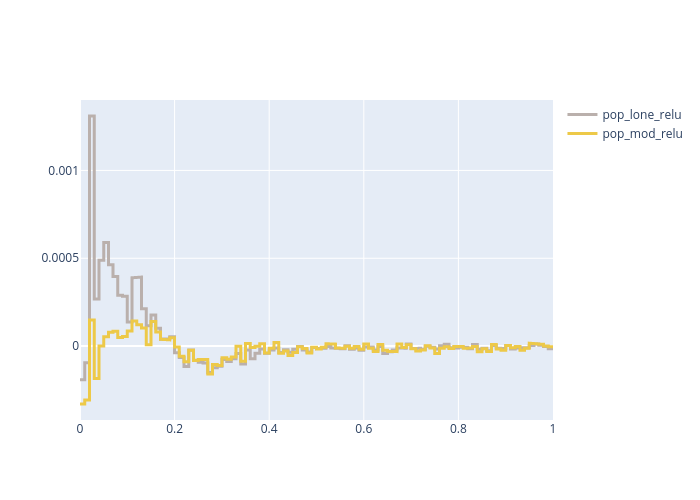

In [35]:
cache_file = pl.Path(config['paths']['analysis_cache']) / '220406_labeled_pooled_errors'
filtered_arr, labels = jl.load(cache_file)


use_pca = False
nPCs = 3
neu, tme = pooled_diff_err['pop_mod_relu'].shape
fs = int(re.findall('\.fs\d*\.', modelnames['pop_mod_relu'])[0][3:-1])
duration = tme / fs
time = np.linspace(0, duration, tme, endpoint=False)
colors = [Grey, Yellow, Red, Teal, Brown]
fig = go.Figure()
for mm, nickname in enumerate(['pop_lone_relu', 'pop_mod_relu']):
    pool_err = filtered_arr[:,mm,:]
    color = colors[mm % len(colors)]

    if use_pca:
        pca = PCA(n_components=20)
        toplot = pca.fit_transform(pool_err.T).T # PC by Time
    else:
        toplot = pool_err.mean(axis=0)[np.newaxis,:]
        nPCs = 1


    dashings = ['solid', 'dash', 'dot']
    for pc in range(nPCs):
        if use_pca:
            name = f'{nickname}_PC{pc}'
        else:
            name = nickname

        x, y = squarefy(time, toplot[pc,:])
        fig.add_trace(go.Scatter(x=x, y=y, mode='lines',
                                 line=dict(color=color,
                                           width=3,
                                           dash=dashings[pc%len(dashings)]),
                                 name=name, showlegend=True))

        # inset for variance explained
        if use_pca:
            fig.add_trace(go.Scatter(x=list(range(1,len(pca.explained_variance_ratio_)+1)),
                                     y=np.cumsum(pca.explained_variance_ratio_),
                                     mode='lines+markers', line_color=color, marker_color=color,
                                     xaxis='x2', yaxis='y2', showlegend=False)
                          )

    if use_pca:
        fig.update_layout(xaxis2=dict(domain=[0.4,0.95], anchor='y2', title_text='PC#'),
                          yaxis2=dict(domain=[0.4,0.95], anchor='x2', title_text='var explained')
                          )

# fig.show()
img_bytes = fig.to_image(format="png")
Image(img_bytes)

In [30]:
summary_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220310_ctx_mod_metric_DF_tstat_cluster_mass_BS'
DF = jl.load(summary_DF_file)
filtered = DF.query(
    f"mult_comp_corr == 'bf_cp' and source == 'real' and "
    f"cluster_threshold == 0.05 and value > 0 and id in {list(cellid_fit_set)}"
)
actual_mean_metrics = filtered.groupby(['metric']).agg(value=('value','mean'))
actual_mean_metrics

,value
metric,
integral,454.961763
integral_trunc,382.039074
last_bin,145.432840
mass_center,103.089448
mass_center_trunc,216.263764


## plain difference
calculated for signficant instancese, for the real data, and model predictions; and flipped so the sum difference is possitive

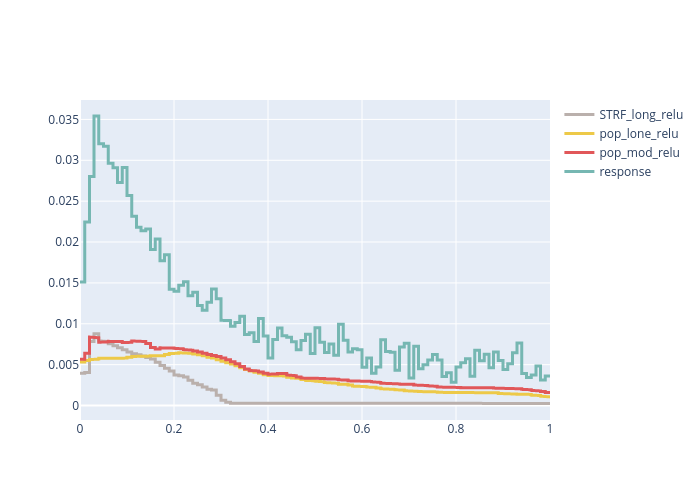

In [34]:
cache_file = pl.Path(config['paths']['analysis_cache']) / '220406_labeled_pooled_differences'
model_diff, resp_diff, labels = jl.load(cache_file)

srcs = ['STRF_long_relu', 'pop_lone_relu', 'pop_mod_relu']
all_difference = {src:arr for src, arr in zip(srcs, np.swapaxes(model_diff, 0, 1))} # swap axes to iterate over models not neurons
all_difference['response'] = resp_diff

use_pca = False
nPCs = 3
neu, tme = pooled_diff_err['pop_mod_relu'].shape
fs = int(re.findall('\.fs\d*\.', modelnames['pop_mod_relu'])[0][3:-1])
duration = tme / fs
time = np.linspace(0, duration, tme, endpoint=False)
colors = [Grey, Yellow, Red, Teal, Brown]
fig = go.Figure()
for mm, (nickname, diff_arr) in enumerate(all_difference.items()): # hardwired order, careful!
    color = colors[mm % len(colors)]

    if use_pca:
        pca = PCA(n_components=20)
        toplot = pca.fit_transform(diff_arr.T).T # PC by Time
    else:
        toplot = diff_arr.mean(axis=0)[np.newaxis,:]
        nPCs = 1


    dashings = ['solid', 'dash', 'dot']
    for pc in range(nPCs):
        if use_pca:
            name = f'{nickname}_PC{pc}'
        else:
            name = nickname

        x, y = squarefy(time, toplot[pc,:])
        fig.add_trace(go.Scatter(x=x, y=y, mode='lines',
                                 line=dict(color=color,
                                           width=3,
                                           dash=dashings[pc%len(dashings)]),
                                 name=name, showlegend=True))

        # inset for variance explained
        if use_pca:
            fig.add_trace(go.Scatter(x=list(range(1,len(pca.explained_variance_ratio_)+1)),
                                     y=np.cumsum(pca.explained_variance_ratio_),
                                     mode='lines+markers', line_color=color, marker_color=color,
                                     xaxis='x2', yaxis='y2', showlegend=False)
                          )

    if use_pca:
        fig.update_layout(xaxis2=dict(domain=[0.4,0.95], anchor='y2', title_text='PC#'),
                          yaxis2=dict(domain=[0.4,0.95], anchor='x2', title_text='var explained')
                          )

# fig.show()
img_bytes = fig.to_image(format="png")
Image(img_bytes)